In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [4]:
(x_train, _), (x_test, _) = cifar10.load_data()

In [5]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [7]:
imgs_dir = 'savedimages'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

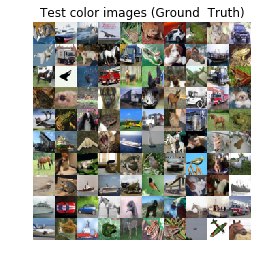

In [8]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [9]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

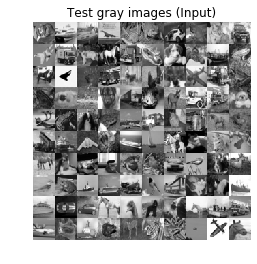

In [10]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [11]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [12]:
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [13]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [14]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

In [15]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256

In [16]:
layer_filters = [64, 128, 256]

In [17]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [18]:
shape = K.int_shape(x)

In [19]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [20]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________________________


In [21]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [22]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

In [23]:
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [24]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731      
Total para

In [25]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               1418496   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [26]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [27]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5,
                               verbose=1, min_lr=0.5e-6)

In [28]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',verbose=1,
                             save_best_only=True)

In [29]:
autoencoder.compile(loss='mse', optimizer='adam')

In [30]:
callbacks = [lr_reducer, checkpoint]

In [ ]:
# train the autoencoder
autoencoder.fit(x_train_gray, x_train, validation_data=(x_test_gray, x_test),
                epochs=30,batch_size=batch_size, callbacks=callbacks)


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 207s 4ms/step - loss: 0.0151 - val_loss: 0.0108

Epoch 00001: val_loss improved from inf to 0.01079, saving model to /home/nebex/saved_models/colorized_ae_model.001.h5
Epoch 2/30
50000/50000 [==============================] - 196s 4ms/step - loss: 0.0101 - val_loss: 0.0094

Epoch 00002: val_loss improved from 0.01079 to 0.00942, saving model to /home/nebex/saved_models/colorized_ae_model.002.h5
Epoch 3/30
50000/50000 [==============================] - 199s 4ms/step - loss: 0.0091 - val_loss: 0.0087

Epoch 00003: val_loss improved from 0.00942 to 0.00874, saving model to /home/nebex/saved_models/colorized_ae_model.003.h5
Epoch 4/30
50000/50000 [==============================] - 195s 4ms/step - loss: 0.0085 - val_loss: 0.0084

Epoch 00004: val_loss improved from 0.00874 to 0.00837, saving model to /home/nebex/saved_models/colorized_ae_model.004.h5
Epoch 5/30
50000/50000 [==========

In [ ]:
x_decoded = autoencoder.predict(x_test_gray)

In [ ]:
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()